In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
from model.text_normalizer import normalize_corpus, stopword_list
from model import evaluation
from model.utils import decoder
from scripts.build_df import build_df
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scripts import tree_utils
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import coo_matrix, hstack, vstack
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier

import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = build_df(json_path='data/products.json', 
             threshold=100, 
             preprocessed_csv=None
            )
df = pd.read_csv('data/products_v1.csv')

def normalization(input):
    output = normalize_corpus(
        input,
        html_stripping=True,
        contraction_expansion=True,
        accented_char_removal=True,
        text_lower_case=True,
        text_stemming=True,
        text_lemmatization=False,
        special_char_removal=True,
        remove_digits=False,
        stopword_removal=True,
        stopwords=stopword_list
    )       
    return output

df['name'] = normalization(df['name'].apply(str))
df['description'] = normalization(df['description'].apply(str))
df['name_and_description'] = [' '.join(i) for i in zip(df['name'], df['description'])]
normalized_data = df.to_csv('data/normalized_data.csv', index=False)

In [207]:
cat = build_df(json_path='data/products.json', 
             threshold=100, 
             preprocessed_csv='data/normalized_data.csv'
            ) 

In [169]:
cat

,name,description,leaf,max_depth,path,category,category_0,category_1,category_2,category_3,category_4,category_5,category_6
0,duracel aaa batteri 4pack,compat select electron devic aaa size duralock...,Household Batteries,3,"[Connected Home & Housewares, Housewares, Hous...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
1,duracel aa 15v coppertop batteri 4pack,longlast energi duralock power preserv technol...,Household Batteries,3,"[Connected Home & Housewares, Housewares, Hous...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
2,duracel aa batteri 8pack,compat select electron devic aa size duralock ...,Household Batteries,3,"[Connected Home & Housewares, Housewares, Hous...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
3,energ max batteri aa 4pack,4pack aa alkalin batteri batteri tester includ,Household Batteries,3,"[Connected Home & Housewares, Housewares, Hous...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
4,duracel c batteri 4pack,compat select electron devic c size duralock p...,Household Batteries,3,"[Connected Home & Housewares, Housewares, Hous...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51641,honeywel true hepa replac filter select honeyw...,compat select honeywel air purifi model captur...,Air Purifier Filters & Parts,3,"[Appliances, Appliance Parts & Accessories, Ai...","[{'id': 'abcat0900000', 'name': 'Appliances'},...",abcat0900000,abcat0916000,pcmcat303700050016,NaN,NaN,NaN,NaN
51642,dyson hard floor wipe dyson hard dc56 vacuum 1...,remov dirt grime hard floor cloth materi 12 wipe,Vacuum & Floor Care Accessories,3,"[Appliances, Appliance Parts & Accessories, Va...","[{'id': 'abcat0900000', 'name': 'Appliances'},...",abcat0900000,abcat0916000,abcat0916008,NaN,NaN,NaN,NaN
51643,aleratec drive enclosur intern black,1 x total bay 1 x 25 bay,External Hard Drives,4,"[Computers & Tablets, Computer Accessories & P...","[{'id': 'abcat0500000', 'name': 'Computers & T...",abcat0500000,abcat0515000,abcat0504001,pcmcat186100050005,NaN,NaN,NaN
51644,amazon fire tv stick,stream 1080p content dualband dualantenna wifi...,TV & Home Theater,1,[TV & Home Theater],"[{'id': 'abcat0100000', 'name': 'TV & Home The...",abcat0100000,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
name = df['name']
description = df['description']
name_desc = df[['name', 'description']]
name_and_description = df['name_and_description']

In [209]:
cat['path'] = cat.path.apply(decoder)

In [33]:
cat['leaf'].apply(decoder)1

0                    Household Batteries
1                    Household Batteries
2                    Household Batteries
3                    Household Batteries
4                    Household Batteries
                      ...               
51641       Air Purifier Filters & Parts
51642    Vacuum & Floor Care Accessories
51643               External Hard Drives
51644                  TV & Home Theater
51645                           Toasters
Name: leaf, Length: 51646, dtype: object

In [34]:
catdd

,name,description,leaf,max_depth,path,category,category_0,category_1,category_2,category_3,category_4,category_5,category_6
0,duracel aaa batteri 4pack,compat select electron devic aaa size duralock...,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
1,duracel aa 15v coppertop batteri 4pack,longlast energi duralock power preserv technol...,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
2,duracel aa batteri 8pack,compat select electron devic aa size duralock ...,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
3,energ max batteri aa 4pack,4pack aa alkalin batteri batteri tester includ,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
4,duracel c batteri 4pack,compat select electron devic c size duralock p...,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51641,honeywel true hepa replac filter select honeyw...,compat select honeywel air purifi model captur...,pcmcat303700050016,3,"[abcat0900000, abcat0916000, pcmcat303700050016]","[{'id': 'abcat0900000', 'name': 'Appliances'},...",abcat0900000,abcat0916000,pcmcat303700050016,NaN,NaN,NaN,NaN
51642,dyson hard floor wipe dyson hard dc56 vacuum 1...,remov dirt grime hard floor cloth materi 12 wipe,abcat0916008,3,"[abcat0900000, abcat0916000, abcat0916008]","[{'id': 'abcat0900000', 'name': 'Appliances'},...",abcat0900000,abcat0916000,abcat0916008,NaN,NaN,NaN,NaN
51643,aleratec drive enclosur intern black,1 x total bay 1 x 25 bay,pcmcat186100050005,4,"[abcat0500000, abcat0515000, abcat0504001, pcm...","[{'id': 'abcat0500000', 'name': 'Computers & T...",abcat0500000,abcat0515000,abcat0504001,pcmcat186100050005,NaN,NaN,NaN
51644,amazon fire tv stick,stream 1080p content dualband dualantenna wifi...,abcat0100000,1,[abcat0100000],"[{'id': 'abcat0100000', 'name': 'TV & Home The...",abcat0100000,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
cat

,name,description,leaf,max_depth,path,category,category_0,category_1,category_2,category_3,category_4,category_5,category_6
0,duracel aaa batteri 4pack,compat select electron devic aaa size duralock...,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
1,duracel aa 15v coppertop batteri 4pack,longlast energi duralock power preserv technol...,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
2,duracel aa batteri 8pack,compat select electron devic aa size duralock ...,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
3,energ max batteri aa 4pack,4pack aa alkalin batteri batteri tester includ,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
4,duracel c batteri 4pack,compat select electron devic c size duralock p...,pcmcat303600050001,3,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[{'id': 'pcmcat312300050015', 'name': 'Connect...",pcmcat312300050015,pcmcat248700050021,pcmcat303600050001,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51641,honeywel true hepa replac filter select honeyw...,compat select honeywel air purifi model captur...,pcmcat303700050016,3,"[abcat0900000, abcat0916000, pcmcat303700050016]","[{'id': 'abcat0900000', 'name': 'Appliances'},...",abcat0900000,abcat0916000,pcmcat303700050016,NaN,NaN,NaN,NaN
51642,dyson hard floor wipe dyson hard dc56 vacuum 1...,remov dirt grime hard floor cloth materi 12 wipe,abcat0916008,3,"[abcat0900000, abcat0916000, abcat0916008]","[{'id': 'abcat0900000', 'name': 'Appliances'},...",abcat0900000,abcat0916000,abcat0916008,NaN,NaN,NaN,NaN
51643,aleratec drive enclosur intern black,1 x total bay 1 x 25 bay,pcmcat186100050005,4,"[abcat0500000, abcat0515000, abcat0504001, pcm...","[{'id': 'abcat0500000', 'name': 'Computers & T...",abcat0500000,abcat0515000,abcat0504001,pcmcat186100050005,NaN,NaN,NaN
51644,amazon fire tv stick,stream 1080p content dualband dualantenna wifi...,abcat0100000,1,[abcat0100000],"[{'id': 'abcat0100000', 'name': 'TV & Home The...",abcat0100000,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
str_paths = []
for leaf in cat['leaf']:
    partial = []
    for cat in cat['category']:
        partial.append(cat['name'])
    str_paths.append(' > '.join(partial))

TypeError: list indices must be integers or slices, not str

In [210]:
cat['leaf'] = cat.leaf.apply(decoder)

In [211]:
cat['category_0'] = cat.category_0.apply(decoder)

In [212]:
pre = cat[['name', 'description', 'path', 'leaf', 'category_0']]

In [171]:
pre

,name,description,path,leaf,category_0
0,duracel aaa batteri 4pack,compat select electron devic aaa size duralock...,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,pcmcat312300050015
1,duracel aa 15v coppertop batteri 4pack,longlast energi duralock power preserv technol...,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,pcmcat312300050015
2,duracel aa batteri 8pack,compat select electron devic aa size duralock ...,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,pcmcat312300050015
3,energ max batteri aa 4pack,4pack aa alkalin batteri batteri tester includ,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,pcmcat312300050015
4,duracel c batteri 4pack,compat select electron devic c size duralock p...,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,pcmcat312300050015
...,...,...,...,...,...
51641,honeywel true hepa replac filter select honeyw...,compat select honeywel air purifi model captur...,"[Appliances, Appliance Parts & Accessories, Ai...",Air Purifier Filters & Parts,abcat0900000
51642,dyson hard floor wipe dyson hard dc56 vacuum 1...,remov dirt grime hard floor cloth materi 12 wipe,"[Appliances, Appliance Parts & Accessories, Va...",Vacuum & Floor Care Accessories,abcat0900000
51643,aleratec drive enclosur intern black,1 x total bay 1 x 25 bay,"[Computers & Tablets, Computer Accessories & P...",External Hard Drives,abcat0500000
51644,amazon fire tv stick,stream 1080p content dualband dualantenna wifi...,[TV & Home Theater],TV & Home Theater,abcat0100000


In [177]:
pre.category_0.value_counts()

Appliances                     8888
Cell Phones                    6778
Computers & Tablets            5871
Video Games                    5688
Connected Home & Housewares    4542
Audio                          3540
Cameras & Camcorders           3206
Musical Instruments            2973
Car Electronics & GPS          2469
TV & Home Theater              2056
Health, Fitness & Beauty       1265
Toys, Games & Drones            669
Best Buy Gift Cards             454
Name Brands                     214
Wearable Technology             130
Magnolia Home Theater           123
Name: category_0, dtype: int64

In [213]:
pre['name_len'] = pre.name.str.len()
pre['desc_len'] = pre.description.str.len()

/tmp/ipykernel_152/798066683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre['name_len'] = pre.name.str.len()
/tmp/ipykernel_152/798066683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre['desc_len'] = pre.description.str.len()


In [189]:
len(pre.category_0.value_counts())

16

In [214]:
pre

,name,description,path,leaf,category_0,name_len,desc_len
0,duracel aaa batteri 4pack,compat select electron devic aaa size duralock...,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,Connected Home & Housewares,25.0,76
1,duracel aa 15v coppertop batteri 4pack,longlast energi duralock power preserv technol...,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,Connected Home & Housewares,38.0,79
2,duracel aa batteri 8pack,compat select electron devic aa size duralock ...,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,Connected Home & Housewares,24.0,75
3,energ max batteri aa 4pack,4pack aa alkalin batteri batteri tester includ,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,Connected Home & Housewares,26.0,46
4,duracel c batteri 4pack,compat select electron devic c size duralock p...,"[Connected Home & Housewares, Housewares, Hous...",Household Batteries,Connected Home & Housewares,23.0,74
...,...,...,...,...,...,...,...
51641,honeywel true hepa replac filter select honeyw...,compat select honeywel air purifi model captur...,"[Appliances, Appliance Parts & Accessories, Ai...",Air Purifier Filters & Parts,Appliances,71.0,99
51642,dyson hard floor wipe dyson hard dc56 vacuum 1...,remov dirt grime hard floor cloth materi 12 wipe,"[Appliances, Appliance Parts & Accessories, Va...",Vacuum & Floor Care Accessories,Appliances,65.0,48
51643,aleratec drive enclosur intern black,1 x total bay 1 x 25 bay,"[Computers & Tablets, Computer Accessories & P...",External Hard Drives,Computers & Tablets,36.0,24
51644,amazon fire tv stick,stream 1080p content dualband dualantenna wifi...,[TV & Home Theater],TV & Home Theater,TV & Home Theater,20.0,151


<AxesSubplot:xlabel='count', ylabel='category_0'>

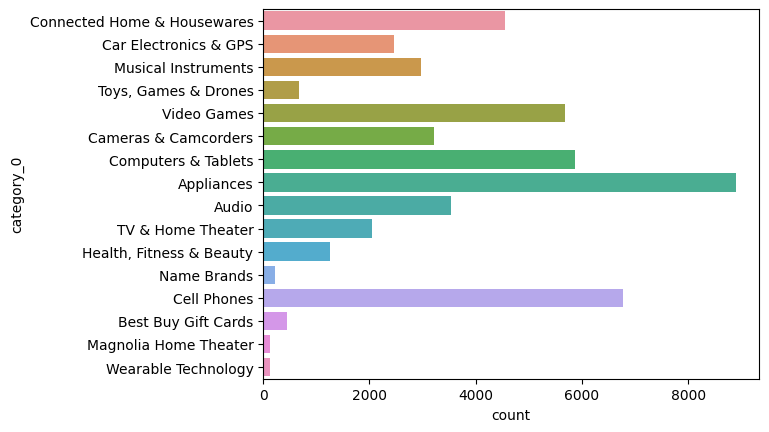

In [215]:
sns.countplot(pre, y='category_0')

## 1. Predicting root

In [387]:
pre.category_0.nunique()

16

In [222]:
y = pre['category_0'].apply(str)
X = name

In [244]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, 
    random_state=42,
    stratify = y
)

In [245]:
tfid_vectorizer = TfidfVectorizer(max_features=None, 
                                  ngram_range=(1, 2),
                                  use_idf=False,
                                  min_df=1,
                                  norm='l2',
                                  smooth_idf=True
                                 ) 
X_train = tfid_vectorizer.fit_transform(X_train)
X_test = tfid_vectorizer.transform(X_test)

In [246]:
logreg = LogisticRegression(max_iter=1000, 
                            n_jobs=-1, 
                            multi_class='multinomial', 
                            solver='newton-cg')

In [220]:
pre['category_0']

0        Connected Home & Housewares
1        Connected Home & Housewares
2        Connected Home & Housewares
3        Connected Home & Housewares
4        Connected Home & Housewares
                    ...             
51641                     Appliances
51642                     Appliances
51643            Computers & Tablets
51644              TV & Home Theater
51645                     Appliances
Name: category_0, Length: 51646, dtype: object

In [247]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='newton-cg')

In [224]:
y_train

47703              Video Games
10913                     None
25859      Computers & Tablets
1591                Appliances
25771      Wearable Technology
                 ...          
32895      Best Buy Gift Cards
6155                     Audio
301      Car Electronics & GPS
16788     Toys, Games & Drones
41806    Car Electronics & GPS
Name: category_0, Length: 41316, dtype: object

In [249]:
print(f'Train:{logreg.score(X_train, y_train)}')
print(f'Test:{logreg.score(X_test, y_test)}')

Train:0.953262658534224
Test:0.9279767666989351


In [227]:
X_test

<10330x99831 sparse matrix of type '<class 'numpy.float64'>'
	with 131041 stored elements in Compressed Sparse Row format>

In [250]:
X = description

In [251]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, 
    random_state=42,
    stratify = y
)

In [252]:
tfid_vectorizer = TfidfVectorizer(max_features=None, 
                                  ngram_range=(1, 2),
                                  use_idf=False,
                                  min_df=1,
                                  norm='l2',
                                  smooth_idf=True
                                 ) 
X_train = tfid_vectorizer.fit_transform(X_train)
X_test = tfid_vectorizer.transform(X_test)

In [253]:
logreg = LogisticRegression(max_iter=1000, 
                            n_jobs=-1, 
                            multi_class='multinomial', 
                            solver='newton-cg')

In [254]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='newton-cg')

In [256]:
print(f'Train:{logreg.score(X_train, y_train)}')
print(f'Test:{logreg.score(X_test, y_test)}')

Train:0.9289379417174944
Test:0.895353339787028


In [260]:
X = name

In [261]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, 
    random_state=42,
    stratify = y
)

In [262]:
tfid_vectorizer = TfidfVectorizer(max_features=None, 
                                  ngram_range=(1, 2),
                                  use_idf=False,
                                  min_df=1,
                                  norm='l2',
                                  smooth_idf=True
                                 ) 
X_train = tfid_vectorizer.fit_transform(X_train)
X_test = tfid_vectorizer.transform(X_test)

In [382]:
random_forest = RandomForestClassifier(n_estimators=100,
                                       max_depth=300,
                                       min_samples_split=10,
                                       min_samples_leaf=1,
                                       n_jobs=-1
                                      )

In [383]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=300, min_samples_split=10, n_jobs=-1)

In [384]:
print(f'Train:{random_forest.score(X_train, y_train)}')
print(f'Test:{random_forest.score(X_test, y_test)}')

Train:0.9782650789040566
Test:0.9265246853823814


## 1. Data & Normalization

In [4]:
cat = build_df(json_path='data/products.json', 
             threshold=100, 
             preprocessed_csv='data/normalized_data.csv'
            ) 

In [5]:
pre = cat[['name', 'description', 'path', 'leaf', 'category_0']]
pre.rename(columns={'category_0':'root'}, inplace=True)

/tmp/ipykernel_1105/28297761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre.rename(columns={'category_0':'root'}, inplace=True)


In [6]:
pre.head(5)

,name,description,path,leaf,root
0,duracel aaa batteri 4pack,compat select electron devic aaa size duralock...,"[pcmcat312300050015, pcmcat248700050021, pcmca...",pcmcat303600050001,pcmcat312300050015
1,duracel aa 15v coppertop batteri 4pack,longlast energi duralock power preserv technol...,"[pcmcat312300050015, pcmcat248700050021, pcmca...",pcmcat303600050001,pcmcat312300050015
2,duracel aa batteri 8pack,compat select electron devic aa size duralock ...,"[pcmcat312300050015, pcmcat248700050021, pcmca...",pcmcat303600050001,pcmcat312300050015
3,energ max batteri aa 4pack,4pack aa alkalin batteri batteri tester includ,"[pcmcat312300050015, pcmcat248700050021, pcmca...",pcmcat303600050001,pcmcat312300050015
4,duracel c batteri 4pack,compat select electron devic c size duralock p...,"[pcmcat312300050015, pcmcat248700050021, pcmca...",pcmcat303600050001,pcmcat312300050015


In [7]:
pre.fillna('other', inplace=True)

/tmp/ipykernel_1105/2398102449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre.fillna('other', inplace=True)


In [8]:
pre.groupby('root')['leaf'].apply(set)

root
abcat0100000          {abcat0106010, abcat0107015, pcmcat15890005001...
abcat0200000          {pcmcat144700050004, pcmcat143000050007, pcmca...
abcat0207000          {pcmcat151600050037, pcmcat152100050020, pcmca...
abcat0300000          {abcat0302037, abcat0301000, pcmcat16590005003...
abcat0400000          {pcmcat233000050008, pcmcat324200050004, abcat...
abcat0500000          {pcmcat186100050005, pcmcat309900050001, abcat...
abcat0700000          {abcat0701002, pcmcat232900050000, abcat070000...
abcat0800000          {abcat0811006, pcmcat326000050010, pcmcat74830...
abcat0900000          {abcat0907007, abcat0912014, pcmcat23290005003...
cat09000                                                     {cat09000}
other                                                           {other}
pcmcat128500050004                                 {pcmcat128500050004}
pcmcat139900050002                                 {pcmcat143200050025}
pcmcat242800050021    {abcat0915005, pcmcat242800050021, ab

In [9]:
# Features
name = pre['name'] 
description = pre['description']
# Labels
root = pre['root']

In [31]:
X = name
y = pre[['root', 'leaf']]

## 2. Train/test split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, 
    random_state=42,
    stratify = y
)

## 3. Feature Engineering

In [80]:
tfid_vectorizer = TfidfVectorizer(max_features=50000, 
                                  ngram_range=(1, 2),
                                  use_idf=False,
                                 ) 
X_train = tfid_vectorizer.fit_transform(X_train)
X_test = tfid_vectorizer.transform(X_test)

## 4. Model #1

In [75]:
model_1 = LogisticRegression(max_iter=5000, 
                            n_jobs=-1, 
                            C=2,
                            multi_class='multinomial', 
                            solver='newton-cg')
model_1.fit(X_train, y_train.iloc[:,0])

LogisticRegression(C=2, max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   solver='newton-cg')

In [62]:
pred = model_1.predict(X_train)
enc = OneHotEncoder(drop='first')
train_roots = enc.fit_transform(pred.reshape(-1, 1))
X_train_2 = hstack([X_train,train_roots])

## 5. Model #2

In [68]:
model_2 = LogisticRegression(max_iter=5000, 
                            n_jobs=-1, 
                            C=2,
                            multi_class='multinomial', 
                            solver='sag')
model_2.fit(X_train_2, y_train.iloc[:,1])

LogisticRegression(C=2, max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   solver='sag')

In [70]:
y_pred = model_1.predict(X_test)
test_roots = enc.transform(y_pred.reshape(-1, 1))
X_test_2 = hstack([X_test,test_roots])
y_pred_2 =model_2.predict(X_test_2)

In [72]:
print(f'Train:{model_1.score(X_train, y_train.iloc[:,0])}')
print(f'Test:{model_1.score(X_test, y_test.iloc[:,0])}')
print(f'Train:{model_2.score(X_train_2, y_train.iloc[:,1])}')
print(f'Test:{model_2.score(X_test_2, y_test.iloc[:,1])}')

Train:0.9670103591828831
Test:0.9344627299128752
Train:0.9269290347565108
Test:0.855082284607938
